### About Dataset:
Monthly average CO2 concentrations (ppm), These data are subject to revision based on recalibration of standard gases. (the record is flask-based.) 
<br>
<br>Source: R. F. Keeling and S. J. Walker
<br>Scripps CO2 Program ( http://scrippsco2.ucsd.edu )
<br>Scripps Institution of Oceanography (SIO)
<br>University of California
<br>La Jolla, California USA 92093-0244

Refernce:
C. D. Keeling, S. C. Piper, R. B. Bacastow, M. Wahlen, T. P. Whorf, M. Heimann, and H. A. Meijer, Exchanges of atmospheric CO2 and 13CO2 with the terrestrial biosphere and oceans from 1978 to 2000.  I. Global aspects, SIO Reference Series, No. 01-06, Scripps Institution of Oceanography, San Diego, 88 pages, 2001.

**Measurment method:**
<br> Monthly CO2 concentrations in micro-mol CO2 per mole (ppm) reported on the 2012 SIO manometric mole fraction scale. alues have been adjusted to 24:00 hours on the 15th of each month. Then after a seasonal adjustment is applyed to remove the quasi-regular seasonal cycle (The adjustment involves subtracting from the data a 4-harmonic fit with a linear gain factor)
<br>Ther are ## missing values in the dataset, these data would be filled by smoothed version of the data generated from a stiff cubic spline function plus 4-harmonic functions with linear gain then with the seasonal cycle removed. 

<br>Missing values are denoted by -99.99.
<br>**The model will be created by column 10.**
## About Approach
The LSTM approach is used to forecast the change of CO2 concentration in south pole. Architecting some Neural Network models, and applying them on test set, their accuracies has been found. Then the forecasting model has been designed by the best of models. Finaly, the behavior of CO2 concentration in south pole hase been forecasted till end of 2029. 

## Creating Model

In [269]:
#importing Libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose



from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

from keras.models import load_model

### Data Preprocessing

In [3]:
# step 2: importing TimeSeries Dataset
df = pd.read_excel("Monthly CO2 in South Pole monthly_merge_co2_spo.xlsx")#, index_col='DATE', parse_dates=True)
df.head()

,Yr,Mn,CO2 (ppm)
0,1957,1,312.83
1,1957,2,312.95
2,1957,3,313.07
3,1957,4,313.20
4,1957,5,313.32


In [4]:
len(df)

792

In [5]:
df.columns

Index(['Yr', 'Mn', 'CO2 (ppm)'], dtype='object')

In [6]:
Date_L = []
for i in range(len(df)):
    d= str(df['Yr'][i]) + "-" +str(df['Mn'][i]) + "-15"
    Date_L.append(d)
    i= i+1
    
df['Date'] = Date_L

df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)
df = df[["CO2 (ppm)"]]
df.head()

,CO2 (ppm)
Date,
1957-01-15,312.83
1957-02-15,312.95
1957-03-15,313.07
1957-04-15,313.20
1957-05-15,313.32


In [7]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

### Time Series

<AxesSubplot:xlabel='Date'>

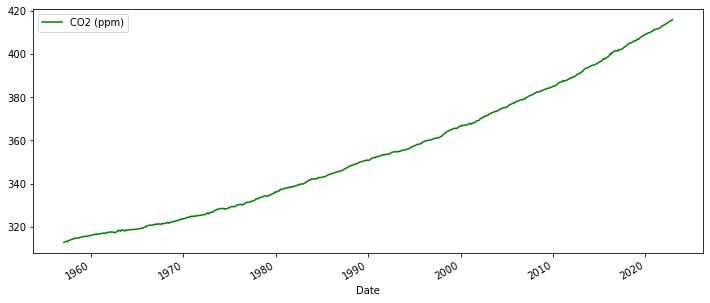

In [8]:
df.plot(figsize= (12,5), c ="g")

Wow!! **What a crazy rising in CO2!!**

In [9]:
#@
#df.index.freq = "ML"
#df_component = seasonal_decompose(df["CO2 (ppm)"])
#df_component

# Creating Prediction models
<br>**Target is creating a LSTM model will forecast the concentration of CO2 monthly in south pole at year 2030 (next 7 years from when the model is defined)**
<br>So, the length of LSTM model is 84 months (=7*12).
<br>The len test set is considered 120 months (10 years), this is the 15% of dataset. 



In [10]:
# Train Test Split regarding Seasonality of TimeSery

test = df.iloc[-120:] # The testsetr includs last 12 years or 120 month
train = df.iloc[:-120]

#train.tail(2)
#test.head(2)

In [11]:
# Scalind Datasets

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

## LSTM model

#### Creating TimeSeries Generator on scaled_train and Validation Generator on scaled_test

In [12]:
length = 84

In [13]:
# scaled_train is used to reproduce itself
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [14]:
# What does the first batch look like?
X,y = generator[0]
print("X.flatten() : ", X.flatten())
print("\ny : ", y)

X.flatten() :  [0.         0.00152886 0.00305771 0.00471398 0.00624283 0.00216588
 0.00955536 0.01108421 0.01274048 0.01426933 0.01579819 0.01911071
 0.0186011  0.02000255 0.02484393 0.02229583 0.02344248 0.02420691
 0.02548095 0.02650019 0.02522614 0.02841126 0.0293031  0.03032233
 0.02981271 0.03363486 0.0347815  0.03388967 0.0347815  0.03567333
 0.03643776 0.03541852 0.03681998 0.03911326 0.0401325  0.04076952
 0.04166136 0.04255319 0.04331762 0.04408205 0.04484648 0.04828641
 0.04892343 0.0453561  0.04790419 0.04854122 0.04930564 0.04994267
 0.0507071  0.05134412 0.05198114 0.05274557 0.05503886 0.05414703
 0.05172633 0.05312779 0.05771436 0.05644031 0.05988024 0.05975283
 0.05988024 0.06077207 0.06000764 0.06038986 0.06013505 0.05911581
 0.0560581  0.05669512 0.06026245 0.06357498 0.06446681 0.07172888
 0.06854376 0.06854376 0.06523124 0.07032743 0.07389476 0.07147407
 0.06854376 0.0694356  0.06663269 0.07262072 0.07172888 0.0721111 ]

y :  [[0.07249331]]


In [15]:
# Creating Validation Generator on scaled_test
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

### Architecting Neural Network for LSTM model

In [16]:
# Architecting 1st Model

In [17]:
n_features = 1 # n_features: the number of features in TimeSeries (here is 1 feature which changed monthly)
# define model
model = Sequential()
model.add(LSTM(500, activation='relu', input_shape=(length, n_features)))#
model.add(Dense(1)) # model Output is one
model.compile(optimizer='adam', loss='mse')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 500)               1004000   
                                                                 
 dense (Dense)               (None, 1)                 501       
                                                                 
Total params: 1,004,501
Trainable params: 1,004,501
Non-trainable params: 0
_________________________________________________________________


#### EarlyStopping on generator

In [19]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

C:\Users\resea\AppData\Local\Temp\ipykernel_8052\3307063739.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


Epoch 1/20
588/588 [==============================] - 150s 249ms/step - loss: 87207120.0000 - val_loss: 1.3848
Epoch 2/20
588/588 [==============================] - 155s 263ms/step - loss: 0.2947 - val_loss: 1.4850
Epoch 3/20
588/588 [==============================] - 146s 248ms/step - loss: 8560983.0000 - val_loss: 1.5893


In [20]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

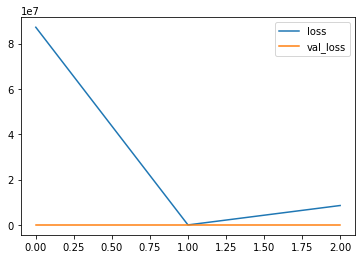

In [21]:
losses.plot()

#### Evaluating model on Test Data

In [67]:
# Predicted 1st value of testset

In [68]:
first_eval_batch = scaled_train[-length:]
first_eval_batch.shape # (n_input, n_features)

(84, 1)

In [69]:
n_input = 84
n_features
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)

1/1 [==============================] - 0s 67ms/step


array([[-0.00505533]], dtype=float32)

In [70]:
scaled_test[0]

array([1.00101924])

In [71]:
scaled_test.mean()

1.159455556971164

In [72]:
# Producing the values of scaled_test by model
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 48ms/step


In [79]:
# inverse transforming
true_predictions = scaler.inverse_transform(test_predictions)
test['model_Predictions'] = true_predictions
test.head(2)

C:\Users\resea\AppData\Local\Temp\ipykernel_8052\2284231002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['model_Predictions'] = true_predictions


,CO2 (ppm),Predictions,model_Predictions
Date,,,
2013-01-15,391.40,312.433207,312.433207
2013-02-15,391.73,311.325790,311.325790


<AxesSubplot:xlabel='Date'>

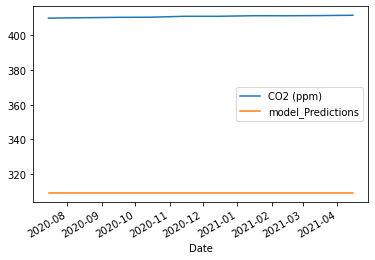

In [253]:
# step 10: ploting
test[["CO2 (ppm)", 'model_Predictions']].iloc[-30:-20].plot(figsize=(6,4))

<AxesSubplot:xlabel='Date'>

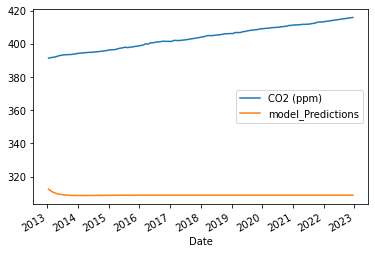

In [254]:
test[["CO2 (ppm)", 'model_Predictions']].plot(figsize=(6,4))

In [83]:
df.tail()

,CO2 (ppm)
Date,
2022-08-15,414.97
2022-09-15,415.20
2022-10-15,415.42
2022-11-15,415.65
2022-12-15,415.87


<AxesSubplot:xlabel='Date'>

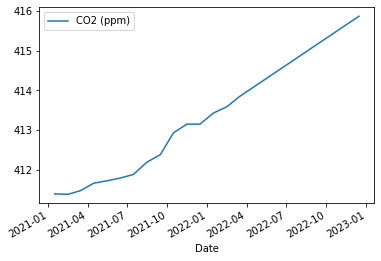

In [84]:
df.iloc[-24:].plot()

In [22]:
# Architecting 2nd Model

In [23]:
# Second Architect
n_features = 1 # n_features: the number of features in TimeSeries (here is 1 feature which changed monthly)
# define model
model2 = Sequential()
model2.add(LSTM(400, activation='relu', input_shape=(length, n_features)))#
model2.add(Dense(1)) # model Output is one
model2.compile(optimizer='adam', loss='mse')

In [24]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 400)               643200    
                                                                 
 dense_1 (Dense)             (None, 1)                 401       
                                                                 
Total params: 643,601
Trainable params: 643,601
Non-trainable params: 0
_________________________________________________________________


In [25]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

# fit model
model2.fit_generator(generator,epochs=6,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/6


C:\Users\resea\AppData\Local\Temp\ipykernel_8052\1095593909.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2.fit_generator(generator,epochs=6,


588/588 [==============================] - 98s 164ms/step - loss: 0.0055 - val_loss: 6.1295e-04
Epoch 2/6
588/588 [==============================] - 95s 161ms/step - loss: 2.0065e-04 - val_loss: 4.2674e-05
Epoch 3/6
588/588 [==============================] - 95s 162ms/step - loss: 1.3486e-04 - val_loss: 1.2113e-05
Epoch 4/6
588/588 [==============================] - 96s 163ms/step - loss: 3.2289e-04 - val_loss: 4.8905e-06
Epoch 5/6
588/588 [==============================] - 96s 163ms/step - loss: 2.0410e-04 - val_loss: 2.5390e-04
Epoch 6/6
588/588 [==============================] - 98s 167ms/step - loss: 1.9672e-04 - val_loss: 4.2173e-06


<AxesSubplot:>

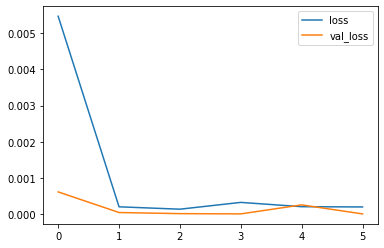

In [26]:
losses2 = pd.DataFrame(model2.history.history)
losses2.plot()

#### Evaluating model2 on Test Data

In [43]:
# Predicted 1st value of testset

In [85]:
first_eval_batch = scaled_train[-length:]
first_eval_batch.shape # (n_input, n_features)

(84, 1)

In [86]:
n_input = 84
n_features
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model2.predict(first_eval_batch)

1/1 [==============================] - 0s 51ms/step


array([[0.9983703]], dtype=float32)

In [87]:
scaled_test[0]

array([1.00101924])

In [88]:
scaled_test.mean()

1.159455556971164

In [89]:
# Producing the values of scaled_test by model
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model2.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 39ms/step


In [90]:
# inverse transforming
true_predictions = scaler.inverse_transform(test_predictions)
test['mode2_Predictions'] = true_predictions
test.head(2)

C:\Users\resea\AppData\Local\Temp\ipykernel_8052\3897207374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['mode2_Predictions'] = true_predictions


,CO2 (ppm),Predictions,model_Predictions,mode2_Predictions
Date,,,,
2013-01-15,391.40,312.433207,312.433207,391.192084
2013-02-15,391.73,311.325790,311.325790,391.346442


<AxesSubplot:xlabel='Date'>

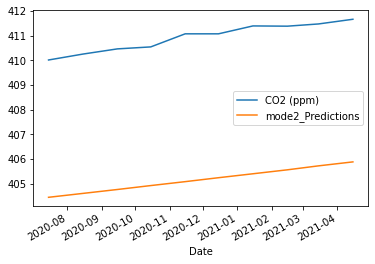

In [248]:
# step 10: ploting
test[["CO2 (ppm)", 'mode2_Predictions']].iloc[-30:-20].plot(figsize=(6,4))

<AxesSubplot:xlabel='Date'>

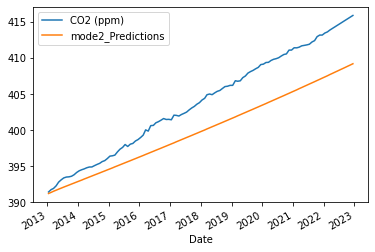

In [249]:
test[["CO2 (ppm)", 'mode2_Predictions']].plot(figsize=(6,4))

In [94]:
df.tail()

,CO2 (ppm)
Date,
2022-08-15,414.97
2022-09-15,415.20
2022-10-15,415.42
2022-11-15,415.65
2022-12-15,415.87


<AxesSubplot:xlabel='Date'>

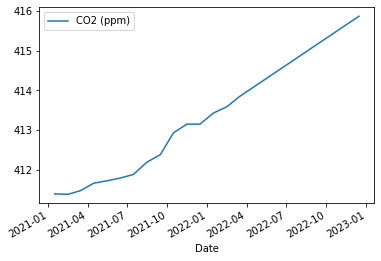

In [95]:
df.iloc[-24:].plot()

In [27]:
# Defining 3rd Model 

In [28]:
# third Architect
n_features = 1 # n_features: the number of features in TimeSeries (here is 1 feature which changed monthly)
# define model
model3 = Sequential()
model3.add(LSTM(100, activation='relu', input_shape=(length, n_features)))#
model3.add(Dense(1)) # model Output is one
model3.compile(optimizer='adam', loss='mse')

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [29]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

# fit model
model3.fit_generator(generator,epochs=20,
                    validation_data=validation_generator
                   , callbacks=[early_stop])

Epoch 1/20


C:\Users\resea\AppData\Local\Temp\ipykernel_8052\2037023461.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model3.fit_generator(generator,epochs=20,


588/588 [==============================] - 15s 23ms/step - loss: 0.0085 - val_loss: 0.0040
Epoch 2/20
588/588 [==============================] - 13s 23ms/step - loss: 9.4504e-05 - val_loss: 0.0035
Epoch 3/20
588/588 [==============================] - 14s 23ms/step - loss: 1.1572e-04 - val_loss: 0.0040
Epoch 4/20
588/588 [==============================] - 13s 22ms/step - loss: 1.3375e-04 - val_loss: 0.0015
Epoch 5/20
588/588 [==============================] - 14s 23ms/step - loss: 6.0830e-05 - val_loss: 1.2427e-04
Epoch 6/20
588/588 [==============================] - 13s 22ms/step - loss: 3.4476e-04 - val_loss: 2.4415e-04
Epoch 7/20
588/588 [==============================] - 13s 23ms/step - loss: 3.8119e-05 - val_loss: 5.3615e-06
Epoch 8/20
588/588 [==============================] - 13s 22ms/step - loss: 6.3048e-05 - val_loss: 1.0790e-04
Epoch 9/20
588/588 [==============================] - 13s 23ms/step - loss: 8.4376e-05 - val_loss: 9.6147e-05
Epoch 10/20
588/588 [====================

<AxesSubplot:>

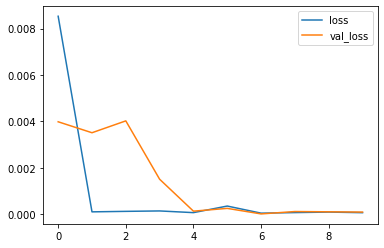

In [30]:
losses3 = pd.DataFrame(model3.history.history)
losses3.plot()

**Conclusion**: *egarding the runing cost adn performance **model3** is selected with **epoch = 4**.*

#### Evaluating model3 on Test Data

In [96]:
first_eval_batch = scaled_train[-length:]
first_eval_batch.shape # (n_input, n_features)

(84, 1)

In [97]:
n_input = 84
n_features
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model3.predict(first_eval_batch)

1/1 [==============================] - 0s 32ms/step


array([[0.9880723]], dtype=float32)

In [98]:
scaled_test[0]

array([1.00101924])

In [99]:
scaled_test.mean()

1.159455556971164

In [100]:
# Producing the values of scaled_test by model
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model3.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 29ms/step


In [102]:
# inverse transforming
true_predictions = scaler.inverse_transform(test_predictions)
test['mode3_Predictions'] = true_predictions
test.head(2)

C:\Users\resea\AppData\Local\Temp\ipykernel_8052\2400451377.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['mode3_Predictions'] = true_predictions


,CO2 (ppm),Predictions,model_Predictions,mode2_Predictions,mode3_Predictions
Date,,,,,
2013-01-15,391.40,390.383793,312.433207,391.192084,390.383793
2013-02-15,391.73,390.420106,311.325790,391.346442,390.420106


<AxesSubplot:xlabel='Date'>

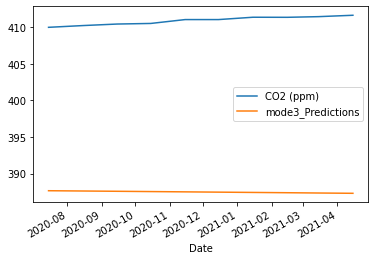

In [255]:
# step 10: ploting
test[["CO2 (ppm)", 'mode3_Predictions']].iloc[-30:-20].plot(figsize=(6,4))

<AxesSubplot:xlabel='Date'>

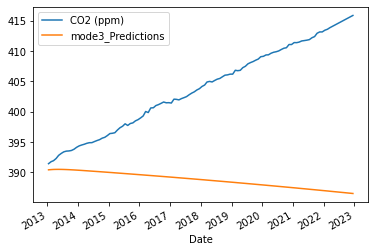

In [256]:
test[["CO2 (ppm)", 'mode3_Predictions']].plot(figsize=(6,4))

In [112]:
# Defining model4
n_features = 1 # n_features: the number of features in TimeSeries (here is 1 feature which changed monthly)
# define model
model4 = Sequential()
model4.add(LSTM(100, return_sequences = True, input_shape=(length, n_features)))#
model4.add(LSTM(100, input_shape=(length, n_features)))
model4.add(Dense(1,  activation = 'sigmoid'))
model4.compile(optimizer='adam', loss='mse')

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 84, 100)           40800     
                                                                 
 lstm_6 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [113]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [114]:
# fit model
model4.fit_generator(generator,epochs=20,
                    validation_data=validation_generator
                   , callbacks=[early_stop])

Epoch 1/20


C:\Users\resea\AppData\Local\Temp\ipykernel_8052\1050532144.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model4.fit_generator(generator,epochs=20,


588/588 [==============================] - 37s 55ms/step - loss: 0.0056 - val_loss: 0.0866
Epoch 2/20
588/588 [==============================] - 29s 50ms/step - loss: 4.5442e-04 - val_loss: 0.0763
Epoch 3/20
588/588 [==============================] - 29s 50ms/step - loss: 4.6019e-04 - val_loss: 0.0797
Epoch 4/20
588/588 [==============================] - 30s 51ms/step - loss: 7.1750e-04 - val_loss: 0.0768
Epoch 5/20
588/588 [==============================] - 30s 51ms/step - loss: 4.9418e-04 - val_loss: 0.0750
Epoch 6/20
588/588 [==============================] - 29s 50ms/step - loss: 3.2297e-04 - val_loss: 0.0737
Epoch 7/20
588/588 [==============================] - 30s 50ms/step - loss: 2.3027e-04 - val_loss: 0.0732
Epoch 8/20
588/588 [==============================] - 29s 50ms/step - loss: 1.3479e-04 - val_loss: 0.0737
Epoch 9/20
588/588 [==============================] - 30s 50ms/step - loss: 3.4293e-04 - val_loss: 0.0723
Epoch 10/20
588/588 [==============================] - 29s 50

<AxesSubplot:>

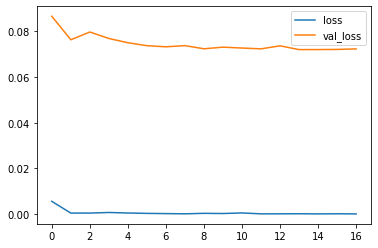

In [116]:
losses4 = pd.DataFrame(model4.history.history)
losses4.plot()

#### Evaluating model4 on Test Data

In [117]:
first_eval_batch = scaled_train[-length:]
first_eval_batch.shape # (n_input, n_features)

(84, 1)

In [118]:
n_input = 84
n_features
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model4.predict(first_eval_batch)

1/1 [==============================] - 1s 1s/step


array([[0.9563055]], dtype=float32)

In [119]:
scaled_test[0]

array([1.00101924])

In [120]:
scaled_test.mean()

1.159455556971164

In [121]:
# Producing the values of scaled_test by model
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model4.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 33ms/step


In [122]:
# inverse transforming
true_predictions = scaler.inverse_transform(test_predictions)
test['mode4_Predictions'] = true_predictions
test.head(2)

C:\Users\resea\AppData\Local\Temp\ipykernel_8052\3431870755.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['mode4_Predictions'] = true_predictions


,CO2 (ppm),Predictions,model_Predictions,mode2_Predictions,mode3_Predictions,mode4_Predictions
Date,,,,,,
2013-01-15,391.40,390.383793,312.433207,391.192084,390.383793,387.890419
2013-02-15,391.73,390.420106,311.325790,391.346442,390.420106,387.891762


<AxesSubplot:xlabel='Date'>

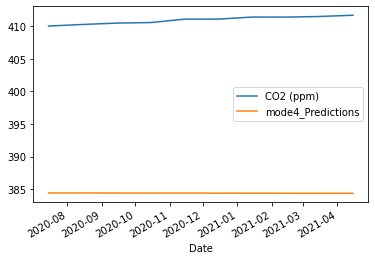

In [258]:
# step 10: ploting
test[["CO2 (ppm)", 'mode4_Predictions']].iloc[-30:-20].plot(figsize=(6,4))

<AxesSubplot:xlabel='Date'>

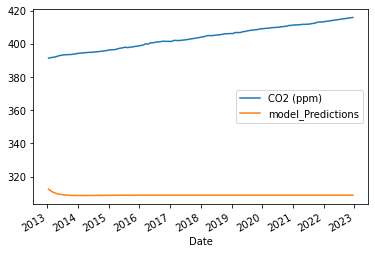

In [259]:
test[["CO2 (ppm)", 'model_Predictions']].plot(figsize=(6,4))

### Shortening the length:
*The Question is: How the shortening the length elevate the accuracy of model2*?

In [136]:
# Second Architect
n_features = 1 # n_features: the number of features in TimeSeries (here is 1 feature which changed monthly)
length = 72
# define model
model5 = Sequential()
model5.add(LSTM(400, activation='relu', input_shape=(length, n_features)))#
model5.add(Dense(1)) # model Output is one
model5.compile(optimizer='adam', loss='mse')

In [137]:
model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 400)               643200    
                                                                 
 dense_6 (Dense)             (None, 1)                 401       
                                                                 
Total params: 643,601
Trainable params: 643,601
Non-trainable params: 0
_________________________________________________________________


In [138]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

# fit model
model5.fit_generator(generator,epochs=6,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/6


C:\Users\resea\AppData\Local\Temp\ipykernel_8052\134167819.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model5.fit_generator(generator,epochs=6,


708/708 [==============================] - 119s 165ms/step - loss: 82191.3125 - val_loss: 0.0238
Epoch 2/6
708/708 [==============================] - 112s 158ms/step - loss: 9.7985e-05 - val_loss: 0.0066
Epoch 3/6
708/708 [==============================] - 113s 159ms/step - loss: 1.7137e-04 - val_loss: 0.0027
Epoch 4/6
708/708 [==============================] - 111s 157ms/step - loss: 2.0244e-04 - val_loss: 0.0030
Epoch 5/6
708/708 [==============================] - 113s 160ms/step - loss: 2.0293e-04 - val_loss: 0.0024
Epoch 6/6
708/708 [==============================] - 111s 157ms/step - loss: 1.0535e-04 - val_loss: 5.4529e-05


<AxesSubplot:>

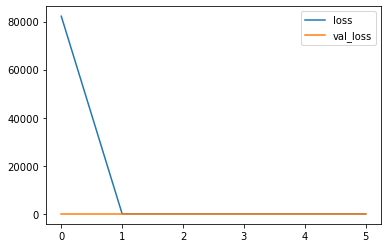

In [139]:
losses5 = pd.DataFrame(model5.history.history)
losses5.plot()

#### Evaluating model5 on Test Data

In [140]:
first_eval_batch = scaled_train[-length:]
first_eval_batch.shape # (n_input, n_features)

(72, 1)

In [141]:
n_input = 72
n_features
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model5.predict(first_eval_batch)

1/1 [==============================] - 0s 216ms/step


array([[0.9781738]], dtype=float32)

In [233]:
# Producing the values of scaled_test by model
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model5.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 37ms/step


In [234]:
# inverse transforming
true_predictions = scaler.inverse_transform(test_predictions)
test['mode5_Predictions'] = true_predictions
test.head(2)

C:\Users\resea\AppData\Local\Temp\ipykernel_8052\3500245491.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['mode5_Predictions'] = true_predictions


,CO2 (ppm),model_Predictions,mode2_Predictions,mode3_Predictions,mode4_Predictions,mode5_Predictions
Date,,,,,,
2013-01-15,391.40,312.433207,391.192084,390.383793,387.890419,413.618792
2013-02-15,391.73,311.325790,391.346442,390.420106,387.891762,413.731670


### The Best_of_Best (BoB)

In [235]:
test = test[['CO2 (ppm)', 'model_Predictions', 'mode2_Predictions','mode3_Predictions', 'mode4_Predictions', 'mode5_Predictions']]

In [237]:
print("Standar Deviation of CO2 (ppm): ", df["CO2 (ppm)"].std())
print("mean_absolute_error of model1 : " , mean_absolute_error(test["CO2 (ppm)"], test["model_Predictions"]))
print("mean_absolute_error of model2 : " , mean_absolute_error(test["CO2 (ppm)"], test["mode2_Predictions"]))
print("mean_absolute_error of model3 : " , mean_absolute_error(test["CO2 (ppm)"], test["mode3_Predictions"]))
print("mean_absolute_error of model4 : " , mean_absolute_error(test["CO2 (ppm)"], test["mode4_Predictions"]))
print("mean_absolute_error of model5 : " , mean_absolute_error(test["CO2 (ppm)"], test["mode5_Predictions"]))

Standar Deviation of CO2 (ppm):  29.748345754650526
mean_absolute_error of model1 :  94.93309256710238
mean_absolute_error of model2 :  3.921346803158479
mean_absolute_error of model3 :  15.139835877488016
mean_absolute_error of model4 :  18.614419628406527
mean_absolute_error of model5 :  11.582742718060814


<AxesSubplot:xlabel='Date'>

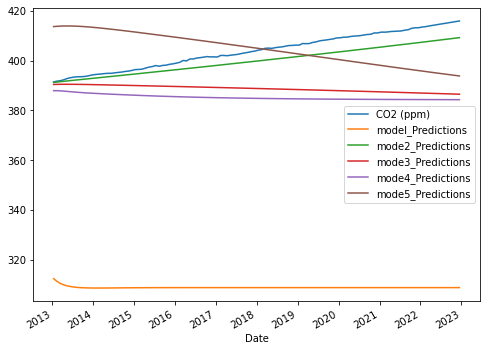

In [261]:
test.plot(figsize=(8,6))

**Conclusion: Model2 is our BoB LSTM model.**

In [146]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 400)               643200    
                                                                 
 dense_5 (Dense)             (None, 1)                 401       
                                                                 
Total params: 643,601
Trainable params: 643,601
Non-trainable params: 0
_________________________________________________________________


## Forecasting by BoB LSTM model (model2)

In [152]:
# step 11: Retrain on whole dataset and Forecasting
scaler = MinMaxScaler()
scaled_full_data = scaler.fit_transform(df)

In [153]:
# Generating TimeSery by whole df dataset
length = 84
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [154]:
# Second Architect
n_features = 1 # n_features: the number of features in TimeSeries (here is 1 feature which changed monthly)

# define model
model2 = Sequential()
model2.add(LSTM(400, activation='relu', input_shape=(length, n_features)))#
model2.add(Dense(1)) # model Output is one
model2.compile(optimizer='adam', loss='mse')

In [155]:
# fit model
model2.fit_generator(generator,epochs=4) # Choosing epochs regarding the performance of losses in pervious step

Epoch 1/4


C:\Users\resea\AppData\Local\Temp\ipykernel_8052\3173491005.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2.fit_generator(generator,epochs=4) # Choosing epochs regarding the performance of losses in pervious step


708/708 [==============================] - 118s 165ms/step - loss: 0.0156
Epoch 2/4
708/708 [==============================] - 112s 158ms/step - loss: 1.5725e-04
Epoch 3/4
708/708 [==============================] - 111s 157ms/step - loss: 7.7958e-05
Epoch 4/4
708/708 [==============================] - 112s 159ms/step - loss: 1.2116e-04


In [195]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 72
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

In [196]:
for i in range(periods):
    current_pred = model2.predict(current_batch)[0]
    forecast.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 38ms/step


In [197]:
forecast = scaler.inverse_transform(forecast)
forecast

array([[417.17571747],
       [417.49159546],
       [417.81825821],
       [418.15410889],
       [418.49814026],
       [418.84930824],
       [419.20691269],
       [419.57040085],
       [419.93902344],
       [420.31248566],
       [420.69041901],
       [421.0727375 ],
       [421.45934288],
       [421.85022285],
       [422.24536514],
       [422.64478203],
       [423.04851036],
       [423.45666069],
       [423.8692453 ],
       [424.28642387],
       [424.70825783],
       [425.13480858],
       [425.56627266],
       [426.00260094],
       [426.44410049],
       [426.89085732],
       [427.34292053],
       [427.80048668],
       [428.26372772],
       [428.73274193],
       [429.20766441],
       [429.68876541],
       [430.17611862],
       [430.66987144],
       [431.1703064 ],
       [431.67750946],
       [432.1917263 ],
       [432.71304291],
       [433.24179092],
       [433.77804405],
       [434.32206024],
       [434.87408516],
       [435.43427849],
       [436

In [198]:
### Creating new timestamp index with pandas
df.tail(5)

,CO2 (ppm)
Date,
2022-08-15,414.97
2022-09-15,415.20
2022-10-15,415.42
2022-11-15,415.65
2022-12-15,415.87


In [199]:
from datetime import timedelta
forecast_index = pd.date_range(start='2022-12-15',periods=periods,freq='MS')+timedelta(days=14)
forecast_index

DatetimeIndex(['2023-01-15', '2023-02-15', '2023-03-15', '2023-04-15',
               '2023-05-15', '2023-06-15', '2023-07-15', '2023-08-15',
               '2023-09-15', '2023-10-15', '2023-11-15', '2023-12-15',
               '2024-01-15', '2024-02-15', '2024-03-15', '2024-04-15',
               '2024-05-15', '2024-06-15', '2024-07-15', '2024-08-15',
               '2024-09-15', '2024-10-15', '2024-11-15', '2024-12-15',
               '2025-01-15', '2025-02-15', '2025-03-15', '2025-04-15',
               '2025-05-15', '2025-06-15', '2025-07-15', '2025-08-15',
               '2025-09-15', '2025-10-15', '2025-11-15', '2025-12-15',
               '2026-01-15', '2026-02-15', '2026-03-15', '2026-04-15',
               '2026-05-15', '2026-06-15', '2026-07-15', '2026-08-15',
               '2026-09-15', '2026-10-15', '2026-11-15', '2026-12-15',
               '2027-01-15', '2027-02-15', '2027-03-15', '2027-04-15',
               '2027-05-15', '2027-06-15', '2027-07-15', '2027-08-15',
      

In [200]:
forecast_CO2 = pd.DataFrame(data=forecast,index=forecast_index, columns=['Forecast'])
forecast_CO2.head(2)

,Forecast
2023-01-15,417.175717
2023-02-15,417.491595


<AxesSubplot:>

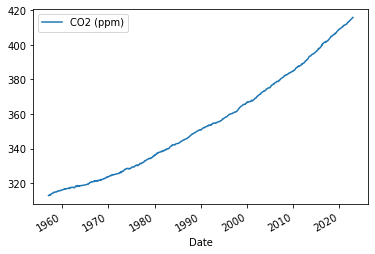

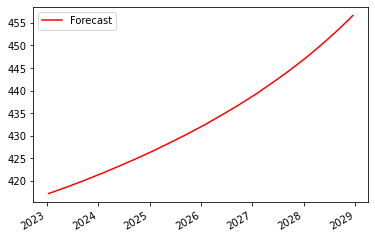

In [203]:
#plotting
df.plot()
forecast_CO2.plot(c="r")

<AxesSubplot:xlabel='Date'>

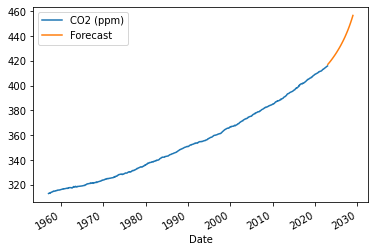

In [242]:
# Joining Plots
ax = df.plot()
forecast_CO2.plot(ax=ax)

(410.0, 463.82721354293824)

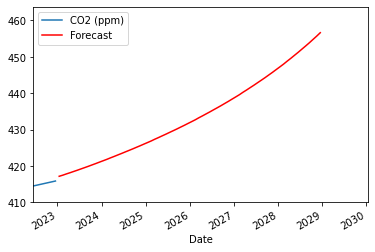

In [238]:
# Zoom in on plot
ax = df.plot()
forecast_CO2.plot(ax=ax, c = "r")
plt.xlim('2022-06-15','2030-01-15')
plt.ylim(410,)

## Saving Final model

In [278]:
from tensorflow.keras.models import load_model

model2.save('model_LSTM_CO2.h5')
del model2  # deletes the existing model

In [275]:
# returns a compiled model
# identical to the previous one
#model2 = load_model('model_LSTM_CO2.h5')

In [277]:
#model2.summary()